In [2]:
from google.colab import files
import io
import numpy as np
import pandas as pd
from tensorflow import keras
import plotly.express as pl
import random
import matplotlib.pyplot as plt
import seaborn as sns

Upload file

In [4]:
uploaded = files.upload()

Saving test.json to test.json
Saving train.json to train (1).json


In [5]:
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']

In [6]:
input_cols = ['sequence', 'structure', 'predicted_loop_type']

In [7]:
train = pd.read_json(io.BytesIO(uploaded['train.json']), lines=True).drop('index', axis=1)
test = pd.read_json(io.BytesIO(uploaded['test.json']), lines=True).drop('index', axis=1)

In [8]:
train = train.query("signal_to_noise >= 1")

In [9]:
train = train.query("SN_filter == 1")

In [10]:
test_private = test.query("seq_length == 130")

In [11]:
test_public = test.query("seq_length == 107")

In [12]:
train.head()

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...,4.136,1,107,68,"[0.1942, 0.2041, 0.1626, 0.1213, 0.10590000000...","[0.2726, 0.2984, 0.21660000000000001, 0.1637, ...","[0.3393, 0.2728, 0.2005, 0.1703, 0.1495, 0.134...","[0.165, 0.20520000000000002, 0.179, 0.1333, 0....","[0.2864, 0.24710000000000001, 0.2222, 0.1903, ...","[0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...","[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0..."
6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...,2.485,1,107,68,"[0.422, 0.5478000000000001, 0.4749000000000000...","[0.4801, 0.7943, 0.42160000000000003, 0.397300...","[0.9822000000000001, 1.272, 0.6940000000000001...","[0.5827, 0.7555000000000001, 0.5949, 0.4511, 0...","[0.9306000000000001, 1.0496, 0.5844, 0.7796000...","[0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...","[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1..."
7,id_00b436dec,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...,.....(((((((((((..(((((((((..((((....))))..)))...,EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...,1.727,1,107,68,"[0.4843, 0.5233, 0.4554, 0.43520000000000003, ...","[0.8719, 1.0307, 0.6649, 0.34500000000000003, ...","[0.7045, 0.7775000000000001, 0.5662, 0.4561, 0...","[0.384, 0.723, 0.4766, 0.30260000000000004, 0....","[0.7429, 0.9137000000000001, 0.480400000000000...","[1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...","[1.6912, 5.2652, 2.3901, 0.45890000000000003, ...","[1.8641, 2.3767, 1.149, 1.0132, 0.9876, 0.0, 0...","[0.49060000000000004, 4.6339, 1.95860000000000...","[1.2852000000000001, 2.5460000000000003, 0.234..."


In [13]:
def preprocess_inputs(df,input_cols):
    """
    Converts inputs into one-hot
    """
    output = []
    for i in range(len(input_cols)):
        tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
        tokenizer.fit_on_texts(np.asarray(df[input_cols[i]]))
        tmp = tokenizer.texts_to_sequences(np.asarray(df[input_cols[i]]))
        output.append(np.asarray(keras.utils.to_categorical(tmp)[:,:,1:]))
    return output

In [14]:
inputs = preprocess_inputs(train,input_cols)

In [15]:
len(inputs[0])

1587

In [16]:
def merge_inputs(inputs, length):
    """
    Merges the one-hot inputs by columns
    Also snips seq length's till desired amount
    """
    size = len(inputs[0])
    output = []
    for i in range(size):
        output.append(np.concatenate((inputs[0][i][0:length], inputs[1][i][0:length], inputs[2][i][0:length]), axis = 1))
    return np.asarray(output)

In [17]:
inputs_simple = merge_inputs(inputs, 68)

In [18]:
inputs_simple.shape

(1587, 68, 14)

In [19]:
test1 = np.zeros((2,5,5))

In [20]:
test1[1,1,0:3]

array([0., 0., 0.])

In [21]:
def preprocess_results(df, results):
    """
    Makes sure that the results are in the appropriate format:
        [layers,lines,columns] in an np array
    """
    tmp = np.asarray(df[results])
    size = len(tmp[0])
    output = np.zeros((len(tmp),len(tmp[0][0]),len(results)))
    for i in range(len(results)):
        for j in range(size):
            tmp[i,j] = np.asarray(tmp[i,j])
    for i in range(len(tmp)):
        output[i] = np.vstack((tmp[i,0], tmp[i,1], tmp[i,2], 
                                tmp[i,3], tmp[i,4]))[:,:].T
    return output

In [22]:
expected_results = preprocess_results(train, pred_cols)

In [23]:
expected_results.shape

(1587, 68, 5)

In [24]:
expected_results[0,0]

array([0.3297, 0.7556, 0.3581, 2.3375, 0.6382])

In [25]:
inputs_simple

array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 1., 0., 0.],
        [1., 0., 0., ..., 1., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 1., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 1., 0., 0.],
        [1., 0., 0., ..., 1., 0., 0.]],

       ...,

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [26]:
model_simple = keras.Sequential()

model_simple.add(keras.layers.Conv1D(filters=10, kernel_size=3, activation=('relu'), 
                                     input_shape=(None,14), padding='same'))
model_simple.add(keras.layers.GlobalMaxPooling1D())
model_simple.add(keras.layers.Dense(20, activation=('relu')))
model_simple.add(keras.layers.Dense(16, activation='relu'))
model_simple.add(keras.layers.Dropout(rate=0.4))
model_simple.add(keras.layers.Dense(10, activation='relu'))


#Est-ce que le out put c'est 3 valuers distinctes, ou 1 valeurs mais qui existe dans 3 channels?
model_simple.add(keras.layers.Dense(68, activation='linear'))

# mean_squared_error car on a affair a une regression
model_simple.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 10)          430       
_________________________________________________________________
global_max_pooling1d (Global (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                336       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_3 (Dense)              (None, 68)                7

In [27]:
model_simple.fit(inputs_simple[:], expected_results[:,:,0], batch_size=64, 
                 epochs=100, verbose=1, validation_split=0.2) # validation loss keeps going down?

Epoch 1/100
20/20 [==============================] - 0s 15ms/step - loss: 0.3526 - mean_squared_error: 0.3526 - val_loss: 0.3344 - val_mean_squared_error: 0.3344
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3194 - mean_squared_error: 0.3194 - val_loss: 0.2997 - val_mean_squared_error: 0.2997
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2829 - mean_squared_error: 0.2829 - val_loss: 0.2591 - val_mean_squared_error: 0.2591
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.2268 - val_mean_squared_error: 0.2268
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2191 - mean_squared_error: 0.2191 - val_loss: 0.1998 - val_mean_squared_error: 0.1998
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1980 - mean_squared_error: 0.1980 - val_loss: 0.1866 - val_mean_squared_error: 0.1866
Epoch 7/100
20/20 [==============

In [28]:
model_simple.predict(inputs_simple)

array([[0.51346254, 1.4580718 , 1.2213931 , ..., 0.4199775 , 0.3711257 ,
        0.30143803],
       [0.5007956 , 1.3818427 , 1.1638906 , ..., 0.4115605 , 0.36685574,
        0.3047244 ],
       [0.5099053 , 1.2626581 , 1.1011269 , ..., 0.37972575, 0.35493454,
        0.29163784],
       ...,
       [0.51884234, 1.4431623 , 1.2095809 , ..., 0.41477343, 0.36662436,
        0.29806095],
       [0.3762568 , 1.0188547 , 0.953037  , ..., 0.39346933, 0.33965886,
        0.28432643],
       [0.5314083 , 1.3398567 , 1.1265485 , ..., 0.37790692, 0.35775673,
        0.3015722 ]], dtype=float32)

In [29]:
inputs_simple_test_public = preprocess_inputs(test_public,input_cols)
inputs_simple_test_public = merge_inputs(inputs_simple_test_public, len(inputs_simple_test_public[0][0]))

In [30]:
inputs_simple_test_public.shape

(629, 107, 14)

In [31]:
model_simple.predict(inputs_simple_test_public)

array([[0.6696112 , 1.9932152 , 1.3461558 , ..., 0.32848597, 0.33706912,
        0.28507596],
       [0.5364001 , 1.442382  , 1.1933231 , ..., 0.4009077 , 0.37014702,
        0.30721277],
       [0.5702498 , 1.5383252 , 1.1728745 , ..., 0.33894747, 0.33374196,
        0.2764038 ],
       ...,
       [0.5760267 , 1.8054546 , 1.334672  , ..., 0.39368623, 0.34920606,
        0.28524828],
       [0.658455  , 1.8805312 , 1.3082061 , ..., 0.33750808, 0.35054457,
        0.29820698],
       [0.50744826, 1.357394  , 1.1497109 , ..., 0.40439302, 0.36160892,
        0.3020383 ]], dtype=float32)

In [32]:
expected_results[:,:,0]

array([[ 0.3297,  1.5693,  1.1227, ...,  0.2937,  0.2362,  0.5731],
       [ 0.4482,  1.4822,  1.1819, ...,  0.6449,  0.04  ,  0.5446],
       [ 0.7642,  1.6641,  1.0622, ...,  0.1107,  0.2261,  0.3238],
       ...,
       [ 0.6957,  1.251 ,  1.3236, ..., -0.0043,  0.0521,  0.0874],
       [ 0.2891,  0.4496,  0.7165, ...,  0.8738,  0.2816,  0.554 ],
       [ 1.0102,  1.7928,  1.9228, ...,  0.0381, -0.0066,  0.0706]])

In [33]:
expected_results[1]

array([[0.4482, 0.2504, 0.5163, 2.243 , 0.9501],
       [1.4822, 1.4021, 1.6823, 2.9361, 1.7975],
       [1.1819, 0.9804, 1.0426, 1.0553, 1.4991],
       [0.7434, 0.4967, 0.7902, 0.721 , 0.8686],
       [0.7148, 0.3653, 0.7477, 0.6396, 0.6893],
       [0.6529, 0.8973, 0.9697, 1.1473, 1.2293],
       [0.2239, 0.296 , 0.2527, 0.3768, 0.3176],
       [0.1927, 0.5758, 0.3151, 0.4777, 0.5927],
       [0.1969, 0.7249, 0.8943, 0.9614, 0.8827],
       [0.3033, 0.1514, 0.1396, 0.1522, 0.1861],
       [0.6176, 0.2885, 0.5329, 0.3904, 0.4771],
       [0.3858, 0.2239, 0.244 , 0.1389, 0.5338],
       [1.0418, 0.9248, 0.796 , 0.4465, 0.7546],
       [0.6581, 2.2196, 2.0522, 1.3107, 1.2277],
       [1.1053, 0.7686, 0.8767, 0.7178, 0.7779],
       [0.6224, 0.3331, 0.4773, 0.2121, 0.4945],
       [0.4591, 0.32  , 0.1956, 0.1804, 0.4322],
       [0.1989, 0.3516, 0.1778, 0.2019, 0.2082],
       [0.1632, 1.3419, 1.0562, 0.5721, 0.6173],
       [0.5538, 0.3321, 0.3052, 0.2512, 0.4662],
       [0.6342, 0.63

In [34]:
seq_input = keras.layers.Input(shape=(None,4), name="seq")      #Input shape a revoir
pair_input = keras.layers.Input(shape=(None,3), name="pair")  
loop_input = keras.layers.Input(shape=(None,7), name="loop")  

seq_features = keras.layers.Conv1D(filters=10, kernel_size=3, activation=('relu'), 
                                     padding='same')(seq_input)
pair_features = keras.layers.Conv1D(filters=10, kernel_size=3, activation=('relu'), 
                                     padding='same')(pair_input)
loop_features = keras.layers.Conv1D(filters=10, kernel_size=3, activation=('relu'), 
                                     padding='same')(loop_input)

seq_features = keras.layers.GlobalMaxPooling1D()(seq_features)
pair_features = keras.layers.GlobalMaxPooling1D()(pair_features)
loop_features = keras.layers.GlobalMaxPooling1D()(loop_features)

seq_features = keras.layers.Dense(20)(seq_features)
pair_features = keras.layers.Dense(20)(pair_features)
loop_features = keras.layers.Dense(20)(loop_features)


# Merge les features
x = keras.layers.concatenate([seq_features, pair_features, loop_features])

flat = keras.layers.Flatten()(x)

first_pred = keras.layers.Dense(68, name="reactivity")(flat) #regression pour "reactivity"
second_pred = keras.layers.Dense(68, name="deg_Mg_pH10")(flat)  #regression pour "ph"
third_pred = keras.layers.Dense(68, name="deg_Mg_50C")(flat)
fourth_pred = keras.layers.Dense(68, name="deg_pH10")(flat)
fifth_pred = keras.layers.Dense(68, name="deg_50C")(flat)


model = keras.Model(
    inputs=[seq_input, pair_input, loop_input],
    outputs=[first_pred, second_pred, third_pred, fourth_pred, fifth_pred],
)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq (InputLayer)                [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
pair (InputLayer)               [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
loop (InputLayer)               [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 10)     130         seq[0][0]                        
_______________________________________________________________________________________

In [35]:
model.fit([inputs_simple[:,:,0:4], inputs_simple[:,:,4:7], inputs_simple[:,:,7:14]],
          [expected_results[:,:,0], expected_results[:,:,1], expected_results[:,:,2],
          expected_results[:,:,3], expected_results[:,:,4]], batch_size = 25, 
          epochs = 30, verbose = 1, validation_split = 0.2)

Epoch 1/30
51/51 [==============================] - 1s 20ms/step - loss: 1.6148 - reactivity_loss: 0.2723 - deg_Mg_pH10_loss: 0.3667 - deg_Mg_50C_loss: 0.3463 - deg_pH10_loss: 0.3343 - deg_50C_loss: 0.2953 - reactivity_mse: 0.2723 - deg_Mg_pH10_mse: 0.3667 - deg_Mg_50C_mse: 0.3463 - deg_pH10_mse: 0.3343 - deg_50C_mse: 0.2953 - val_loss: 0.9211 - val_reactivity_loss: 0.1739 - val_deg_Mg_pH10_loss: 0.2198 - val_deg_Mg_50C_loss: 0.2045 - val_deg_pH10_loss: 0.1782 - val_deg_50C_loss: 0.1446 - val_reactivity_mse: 0.1739 - val_deg_Mg_pH10_mse: 0.2198 - val_deg_Mg_50C_mse: 0.2045 - val_deg_pH10_mse: 0.1782 - val_deg_50C_mse: 0.1446
Epoch 2/30
51/51 [==============================] - 1s 12ms/step - loss: 0.8565 - reactivity_loss: 0.1665 - deg_Mg_pH10_loss: 0.2125 - deg_Mg_50C_loss: 0.1834 - deg_pH10_loss: 0.1614 - deg_50C_loss: 0.1326 - reactivity_mse: 0.1665 - deg_Mg_pH10_mse: 0.2125 - deg_Mg_50C_mse: 0.1834 - deg_pH10_mse: 0.1614 - deg_50C_mse: 0.1326 - val_loss: 0.8422 - val_reactivity_loss

In [50]:
inputs = keras.layers.Input(shape=(None,14))      #Input shape a revoir

features = keras.layers.Conv1D(filters=512, kernel_size=3, activation=('relu'), 
                                     padding='same')(inputs)
features = keras.layers.MaxPooling1D(pool_size = 2)(features)
features = keras.layers.Conv1D(filters=256, kernel_size=3, activation=('relu'), 
                                     padding='same')(features)
features = keras.layers.MaxPooling1D(pool_size = 2)(features)
features = keras.layers.Conv1D(filters=128, kernel_size=3, activation=('relu'), 
                                     padding='same')(features)
features = keras.layers.MaxPooling1D(pool_size = 2)(features)
features = keras.layers.Conv1D(filters=64, kernel_size=3, activation=('relu'), 
                                     padding='same')(features)
features = keras.layers.MaxPooling1D(pool_size = 2)(features)

features = keras.layers.GlobalAveragePooling1D()(features)

#features = keras.layers.MaxPooling1D(pool_size=2)(features)

#flat = keras.backend.batch_flatten(features)

#flat = keras.layers.Flatten()(features)




features = keras.layers.Dense(20)(features)
features = keras.layers.Dropout(rate=0.3)(features)
features = keras.layers.Dense(16)(features)
features = keras.layers.Dropout(rate=0.3)(features)
features = keras.layers.Dense(12)(features)
features = keras.layers.Dropout(rate=0.3)(features)
features = keras.layers.Dense(8)(features)
features = keras.layers.Dropout(rate=0.3)(features)


first_pred = keras.layers.Dense(68, name="reactivity")(features) #regression pour "reactivity"
second_pred = keras.layers.Dense(68, name="deg_Mg_pH10")(features)  #regression pour "ph"
third_pred = keras.layers.Dense(68, name="deg_Mg_50C")(features)
fourth_pred = keras.layers.Dense(68, name="deg_pH10")(features)
fifth_pred = keras.layers.Dense(68, name="deg_50C")(features)


model = keras.Model(
    inputs=inputs,
    outputs=[first_pred, second_pred, third_pred, fourth_pred, fifth_pred],
)
model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
model.summary()


Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 14)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, None, 512)    22016       input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, None, 512)    0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, None, 256)    393472      max_pooling1d_6[0][0]            
_______________________________________________________________________________________

In [51]:
toto = model.fit(inputs_simple,
          [expected_results[:,:,0], expected_results[:,:,1], expected_results[:,:,2],
          expected_results[:,:,3], expected_results[:,:,4]], batch_size = 75, 
          epochs = 500, verbose = 1, validation_split = 0.2)

Epoch 1/500
17/17 [==============================] - 1s 45ms/step - loss: 2.0962 - reactivity_loss: 0.3450 - deg_Mg_pH10_loss: 0.4772 - deg_Mg_50C_loss: 0.4046 - deg_pH10_loss: 0.5162 - deg_50C_loss: 0.3532 - reactivity_root_mean_squared_error: 0.5874 - deg_Mg_pH10_root_mean_squared_error: 0.6908 - deg_Mg_50C_root_mean_squared_error: 0.6361 - deg_pH10_root_mean_squared_error: 0.7185 - deg_50C_root_mean_squared_error: 0.5943 - val_loss: 2.0190 - val_reactivity_loss: 0.3319 - val_deg_Mg_pH10_loss: 0.4648 - val_deg_Mg_50C_loss: 0.3814 - val_deg_pH10_loss: 0.5059 - val_deg_50C_loss: 0.3351 - val_reactivity_root_mean_squared_error: 0.5761 - val_deg_Mg_pH10_root_mean_squared_error: 0.6817 - val_deg_Mg_50C_root_mean_squared_error: 0.6176 - val_deg_pH10_root_mean_squared_error: 0.7113 - val_deg_50C_root_mean_squared_error: 0.5789
Epoch 2/500
17/17 [==============================] - 0s 17ms/step - loss: 1.9764 - reactivity_loss: 0.3238 - deg_Mg_pH10_loss: 0.4572 - deg_Mg_50C_loss: 0.3783 - deg_

In [38]:
#Creation of function that gives train and test set indexes from a pandas dataframe
def data_sep(dataset, data_size, train_size):
    train = random.sample(range(data_size), train_size)
    test = list(range(0,data_size))
    for i in train:
        test.remove(i)
    return(train,test)

In [39]:
train.shape

(1587, 18)

In [ ]:
inputs = inputs_simple
targets = expected_results
num_folds = 10
fold_no = 1
mse_per_fold_reactivity = []
mse_per_fold_deg_Mg_pH10 = []
mse_per_fold_deg_Mg_50C = []
mse_per_fold_deg_pH10 = []
mse_per_fold_deg_50C = []
loss_per_fold_reactivity = []
loss_per_fold_deg_Mg_pH10 = []
loss_per_fold_deg_Mg_50C = []
loss_per_fold_deg_pH10 = []
loss_per_fold_deg_50C = []
while fold_no <= num_folds:
    kf_train_index,kf_test_index = data_sep(train,1587,1300)
    train_in = inputs[kf_train_index,]
    test_in = inputs[kf_test_index,]
    train_out = targets[kf_train_index,]
    test_out = targets[kf_test_index,]

    inputs_model = keras.layers.Input(shape=(None,14))

    features = keras.layers.Conv1D(filters=32, kernel_size=3, activation=('relu'), padding='same')(inputs_model)
    features = keras.layers.MaxPooling1D(pool_size = 2)(features)
    features = keras.layers.Conv1D(filters=16, kernel_size=3, activation=('relu'), padding='same')(features)
    features = keras.layers.MaxPooling1D(pool_size = 2)(features)

    features = keras.layers.GlobalMaxPooling1D()(features)
    
    features = keras.layers.Dense(20)(features)
    features = keras.layers.Dropout(rate=0.3)(features)
    features = keras.layers.Dense(16)(features)
    features = keras.layers.Dropout(rate=0.3)(features)
    features = keras.layers.Dense(12)(features)
    features = keras.layers.Dropout(rate=0.3)(features)
    features = keras.layers.Dense(8)(features)
    features = keras.layers.Dropout(rate=0.3)(features)

    first_pred = keras.layers.Dense(68, name="reactivity")(features) #regression pour "reactivity"
    second_pred = keras.layers.Dense(68, name="deg_Mg_pH10")(features)  #regression pour "ph"
    third_pred = keras.layers.Dense(68, name="deg_Mg_50C")(features)
    fourth_pred = keras.layers.Dense(68, name="deg_pH10")(features)
    fifth_pred = keras.layers.Dense(68, name="deg_50C")(features)

    model = keras.Model(
        inputs=inputs_model,
        outputs=[first_pred, second_pred, third_pred, fourth_pred, fifth_pred],
    )
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = model.fit(train_in, [train_out[:,:,0], train_out[:,:,1], train_out[:,:,2],
                        train_out[:,:,3], train_out[:,:,4]], batch_size=100, epochs=30, verbose=1)
    
    # Generate generalization metrics
    scores = model.evaluate(test_in, [test_out[:,:,0], test_out[:,:,1], test_out[:,:,2],
                        test_out[:,:,3], test_out[:,:,4]], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]}; {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]}; {model.metrics_names[5]} of {scores[5]}')
    print(f'Score for fold {fold_no}: {model.metrics_names[6]} of {scores[6]}; {model.metrics_names[7]} of {scores[7]}; {model.metrics_names[8]} of {scores[8]}; {model.metrics_names[9]} of {scores[9]}; {model.metrics_names[10]} of {scores[10]};')
    mse_per_fold_reactivity.append(scores[6])
    mse_per_fold_deg_Mg_pH10.append(scores[7])
    mse_per_fold_deg_Mg_50C.append(scores[8])
    mse_per_fold_deg_pH10.append(scores[9])
    mse_per_fold_deg_50C.append(scores[10])
    loss_per_fold_reactivity.append(scores[1])
    loss_per_fold_deg_Mg_pH10.append(scores[2])
    loss_per_fold_deg_Mg_50C.append(scores[3])
    loss_per_fold_deg_pH10.append(scores[4])
    loss_per_fold_deg_50C.append(scores[5])
    
    fold_no+=1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
13/13 [==============================] - 0s 11ms/step - loss: 3.1371 - reactivity_loss: 0.5816 - deg_Mg_pH10_loss: 0.6974 - deg_Mg_50C_loss: 0.6132 - deg_pH10_loss: 0.6929 - deg_50C_loss: 0.5520 - reactivity_mse: 0.5816 - deg_Mg_pH10_mse: 0.6974 - deg_Mg_50C_mse: 0.6132 - deg_pH10_mse: 0.6929 - deg_50C_mse: 0.5520
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 2.2206 - reactivity_loss: 0.3735 - deg_Mg_pH10_loss: 0.4999 - deg_Mg_50C_loss: 0.4292 - deg_pH10_loss: 0.5390 - deg_50C_loss: 0.3789 - reactivity_mse: 0.3735 - deg_Mg_pH10_mse: 0.4999 - deg_Mg_50C_mse: 0.4292 - deg_pH10_mse: 0.5390 - deg_50C_mse: 0.3789
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 2.0540 - reactivity_loss: 0.3447 - deg_Mg_pH10_loss: 0.4689 - deg_Mg_50C_loss: 0.3918 - deg_pH10_loss: 0.5014 - deg_50C_loss: 0.3473 - reactivity_mse: 0.3447 - deg_Mg_pH10_mse:

13/13 [==============================] - 0s 11ms/step - loss: 0.9782 - reactivity_loss: 0.1825 - deg_Mg_pH10_loss: 0.2422 - deg_Mg_50C_loss: 0.1969 - deg_pH10_loss: 0.2088 - deg_50C_loss: 0.1478 - reactivity_mse: 0.1825 - deg_Mg_pH10_mse: 0.2422 - deg_Mg_50C_mse: 0.1969 - deg_pH10_mse: 0.2088 - deg_50C_mse: 0.1478
Epoch 26/30
13/13 [==============================] - 0s 12ms/step - loss: 0.9643 - reactivity_loss: 0.1802 - deg_Mg_pH10_loss: 0.2386 - deg_Mg_50C_loss: 0.1936 - deg_pH10_loss: 0.2059 - deg_50C_loss: 0.1460 - reactivity_mse: 0.1802 - deg_Mg_pH10_mse: 0.2386 - deg_Mg_50C_mse: 0.1936 - deg_pH10_mse: 0.2059 - deg_50C_mse: 0.1460
Epoch 27/30
13/13 [==============================] - 0s 8ms/step - loss: 0.9560 - reactivity_loss: 0.1807 - deg_Mg_pH10_loss: 0.2366 - deg_Mg_50C_loss: 0.1926 - deg_pH10_loss: 0.2011 - deg_50C_loss: 0.1450 - reactivity_mse: 0.1807 - deg_Mg_pH10_mse: 0.2366 - deg_Mg_50C_mse: 0.1926 - deg_pH10_mse: 0.2011 - deg_50C_mse: 0.1450
Epoch 28/30
13/13 [==========

13/13 [==============================] - 0s 7ms/step - loss: 1.0774 - reactivity_loss: 0.1931 - deg_Mg_pH10_loss: 0.2625 - deg_Mg_50C_loss: 0.2077 - deg_pH10_loss: 0.2407 - deg_50C_loss: 0.1734 - reactivity_mse: 0.1931 - deg_Mg_pH10_mse: 0.2625 - deg_Mg_50C_mse: 0.2077 - deg_pH10_mse: 0.2407 - deg_50C_mse: 0.1734
Epoch 19/30
13/13 [==============================] - 0s 8ms/step - loss: 1.0578 - reactivity_loss: 0.1912 - deg_Mg_pH10_loss: 0.2594 - deg_Mg_50C_loss: 0.2052 - deg_pH10_loss: 0.2322 - deg_50C_loss: 0.1698 - reactivity_mse: 0.1912 - deg_Mg_pH10_mse: 0.2594 - deg_Mg_50C_mse: 0.2052 - deg_pH10_mse: 0.2322 - deg_50C_mse: 0.1698
Epoch 20/30
13/13 [==============================] - 0s 10ms/step - loss: 1.0314 - reactivity_loss: 0.1880 - deg_Mg_pH10_loss: 0.2540 - deg_Mg_50C_loss: 0.2011 - deg_pH10_loss: 0.2235 - deg_50C_loss: 0.1648 - reactivity_mse: 0.1880 - deg_Mg_pH10_mse: 0.2540 - deg_Mg_50C_mse: 0.2011 - deg_pH10_mse: 0.2235 - deg_50C_mse: 0.1648
Epoch 21/30
13/13 [===========

13/13 [==============================] - 0s 9ms/step - loss: 1.2278 - reactivity_loss: 0.2110 - deg_Mg_pH10_loss: 0.2816 - deg_Mg_50C_loss: 0.2514 - deg_pH10_loss: 0.2950 - deg_50C_loss: 0.1888 - reactivity_mse: 0.2110 - deg_Mg_pH10_mse: 0.2816 - deg_Mg_50C_mse: 0.2514 - deg_pH10_mse: 0.2950 - deg_50C_mse: 0.1888
Epoch 12/30
13/13 [==============================] - 0s 8ms/step - loss: 1.1712 - reactivity_loss: 0.2029 - deg_Mg_pH10_loss: 0.2719 - deg_Mg_50C_loss: 0.2393 - deg_pH10_loss: 0.2785 - deg_50C_loss: 0.1785 - reactivity_mse: 0.2029 - deg_Mg_pH10_mse: 0.2719 - deg_Mg_50C_mse: 0.2393 - deg_pH10_mse: 0.2785 - deg_50C_mse: 0.1785
Epoch 13/30
13/13 [==============================] - 0s 8ms/step - loss: 1.1377 - reactivity_loss: 0.1990 - deg_Mg_pH10_loss: 0.2663 - deg_Mg_50C_loss: 0.2331 - deg_pH10_loss: 0.2662 - deg_50C_loss: 0.1732 - reactivity_mse: 0.1990 - deg_Mg_pH10_mse: 0.2663 - deg_Mg_50C_mse: 0.2331 - deg_pH10_mse: 0.2662 - deg_50C_mse: 0.1732
Epoch 14/30
13/13 [============

13/13 [==============================] - 0s 9ms/step - loss: 1.9010 - reactivity_loss: 0.3223 - deg_Mg_pH10_loss: 0.4254 - deg_Mg_50C_loss: 0.3581 - deg_pH10_loss: 0.4774 - deg_50C_loss: 0.3177 - reactivity_mse: 0.3223 - deg_Mg_pH10_mse: 0.4254 - deg_Mg_50C_mse: 0.3581 - deg_pH10_mse: 0.4774 - deg_50C_mse: 0.3177
Epoch 5/30
13/13 [==============================] - 0s 10ms/step - loss: 1.8081 - reactivity_loss: 0.3087 - deg_Mg_pH10_loss: 0.4041 - deg_Mg_50C_loss: 0.3404 - deg_pH10_loss: 0.4546 - deg_50C_loss: 0.3003 - reactivity_mse: 0.3087 - deg_Mg_pH10_mse: 0.4041 - deg_Mg_50C_mse: 0.3404 - deg_pH10_mse: 0.4546 - deg_50C_mse: 0.3003
Epoch 6/30
13/13 [==============================] - 0s 9ms/step - loss: 1.7127 - reactivity_loss: 0.2962 - deg_Mg_pH10_loss: 0.3820 - deg_Mg_50C_loss: 0.3212 - deg_pH10_loss: 0.4307 - deg_50C_loss: 0.2825 - reactivity_mse: 0.2962 - deg_Mg_pH10_mse: 0.3820 - deg_Mg_50C_mse: 0.3212 - deg_pH10_mse: 0.4307 - deg_50C_mse: 0.2825
Epoch 7/30
13/13 [==============

13/13 [==============================] - 0s 8ms/step - loss: 0.9116 - reactivity_loss: 0.1767 - deg_Mg_pH10_loss: 0.2263 - deg_Mg_50C_loss: 0.1851 - deg_pH10_loss: 0.1844 - deg_50C_loss: 0.1392 - reactivity_mse: 0.1767 - deg_Mg_pH10_mse: 0.2263 - deg_Mg_50C_mse: 0.1851 - deg_pH10_mse: 0.1844 - deg_50C_mse: 0.1392
Epoch 30/30
13/13 [==============================] - 0s 8ms/step - loss: 0.9175 - reactivity_loss: 0.1776 - deg_Mg_pH10_loss: 0.2282 - deg_Mg_50C_loss: 0.1861 - deg_pH10_loss: 0.1850 - deg_50C_loss: 0.1406 - reactivity_mse: 0.1776 - deg_Mg_pH10_mse: 0.2282 - deg_Mg_50C_mse: 0.1861 - deg_pH10_mse: 0.1850 - deg_50C_mse: 0.1406
Score for fold 4: loss of 0.871776282787323; reactivity_loss of 0.1581345945596695; deg_Mg_pH10_loss of 0.22093671560287476; deg_Mg_50C_loss of 0.18406635522842407; deg_pH10_loss of 0.17860078811645508; deg_50C_loss of 0.1300378292798996
Score for fold 4: reactivity_mse of 0.1581345945596695; deg_Mg_pH10_mse of 0.22093671560287476; deg_Mg_50C_mse of 0.1840

13/13 [==============================] - 0s 8ms/step - loss: 0.9751 - reactivity_loss: 0.1783 - deg_Mg_pH10_loss: 0.2341 - deg_Mg_50C_loss: 0.1962 - deg_pH10_loss: 0.2177 - deg_50C_loss: 0.1489 - reactivity_mse: 0.1783 - deg_Mg_pH10_mse: 0.2341 - deg_Mg_50C_mse: 0.1962 - deg_pH10_mse: 0.2177 - deg_50C_mse: 0.1489
Epoch 23/30
13/13 [==============================] - 0s 8ms/step - loss: 0.9631 - reactivity_loss: 0.1775 - deg_Mg_pH10_loss: 0.2328 - deg_Mg_50C_loss: 0.1936 - deg_pH10_loss: 0.2132 - deg_50C_loss: 0.1460 - reactivity_mse: 0.1775 - deg_Mg_pH10_mse: 0.2328 - deg_Mg_50C_mse: 0.1936 - deg_pH10_mse: 0.2132 - deg_50C_mse: 0.1460
Epoch 24/30
13/13 [==============================] - 0s 8ms/step - loss: 0.9543 - reactivity_loss: 0.1771 - deg_Mg_pH10_loss: 0.2322 - deg_Mg_50C_loss: 0.1912 - deg_pH10_loss: 0.2082 - deg_50C_loss: 0.1455 - reactivity_mse: 0.1771 - deg_Mg_pH10_mse: 0.2322 - deg_Mg_50C_mse: 0.1912 - deg_pH10_mse: 0.2082 - deg_50C_mse: 0.1455
Epoch 25/30
13/13 [============

13/13 [==============================] - 0s 7ms/step - loss: 1.0533 - reactivity_loss: 0.1955 - deg_Mg_pH10_loss: 0.2564 - deg_Mg_50C_loss: 0.2101 - deg_pH10_loss: 0.2260 - deg_50C_loss: 0.1653 - reactivity_mse: 0.1955 - deg_Mg_pH10_mse: 0.2564 - deg_Mg_50C_mse: 0.2101 - deg_pH10_mse: 0.2260 - deg_50C_mse: 0.1653
Epoch 16/30
13/13 [==============================] - 0s 7ms/step - loss: 1.0325 - reactivity_loss: 0.1912 - deg_Mg_pH10_loss: 0.2530 - deg_Mg_50C_loss: 0.2071 - deg_pH10_loss: 0.2204 - deg_50C_loss: 0.1608 - reactivity_mse: 0.1912 - deg_Mg_pH10_mse: 0.2530 - deg_Mg_50C_mse: 0.2071 - deg_pH10_mse: 0.2204 - deg_50C_mse: 0.1608
Epoch 17/30
13/13 [==============================] - 0s 7ms/step - loss: 1.0059 - reactivity_loss: 0.1886 - deg_Mg_pH10_loss: 0.2473 - deg_Mg_50C_loss: 0.2009 - deg_pH10_loss: 0.2132 - deg_50C_loss: 0.1559 - reactivity_mse: 0.1886 - deg_Mg_pH10_mse: 0.2473 - deg_Mg_50C_mse: 0.2009 - deg_pH10_mse: 0.2132 - deg_50C_mse: 0.1559
Epoch 18/30
13/13 [============

13/13 [==============================] - 0s 8ms/step - loss: 1.4581 - reactivity_loss: 0.2581 - deg_Mg_pH10_loss: 0.3184 - deg_Mg_50C_loss: 0.2857 - deg_pH10_loss: 0.3471 - deg_50C_loss: 0.2488 - reactivity_mse: 0.2581 - deg_Mg_pH10_mse: 0.3184 - deg_Mg_50C_mse: 0.2857 - deg_pH10_mse: 0.3471 - deg_50C_mse: 0.2488
Epoch 9/30
13/13 [==============================] - 0s 9ms/step - loss: 1.3669 - reactivity_loss: 0.2437 - deg_Mg_pH10_loss: 0.3031 - deg_Mg_50C_loss: 0.2682 - deg_pH10_loss: 0.3201 - deg_50C_loss: 0.2318 - reactivity_mse: 0.2437 - deg_Mg_pH10_mse: 0.3031 - deg_Mg_50C_mse: 0.2682 - deg_pH10_mse: 0.3201 - deg_50C_mse: 0.2318
Epoch 10/30
13/13 [==============================] - 0s 8ms/step - loss: 1.2969 - reactivity_loss: 0.2316 - deg_Mg_pH10_loss: 0.2905 - deg_Mg_50C_loss: 0.2538 - deg_pH10_loss: 0.3017 - deg_50C_loss: 0.2193 - reactivity_mse: 0.2316 - deg_Mg_pH10_mse: 0.2905 - deg_Mg_50C_mse: 0.2538 - deg_pH10_mse: 0.3017 - deg_50C_mse: 0.2193
Epoch 11/30
13/13 [=============

13/13 [==============================] - 0s 8ms/step - loss: 2.4235 - reactivity_loss: 0.4308 - deg_Mg_pH10_loss: 0.5331 - deg_Mg_50C_loss: 0.4497 - deg_pH10_loss: 0.5789 - deg_50C_loss: 0.4310 - reactivity_mse: 0.4308 - deg_Mg_pH10_mse: 0.5331 - deg_Mg_50C_mse: 0.4497 - deg_pH10_mse: 0.5789 - deg_50C_mse: 0.4310
Epoch 2/30
13/13 [==============================] - 0s 7ms/step - loss: 2.0829 - reactivity_loss: 0.3518 - deg_Mg_pH10_loss: 0.4696 - deg_Mg_50C_loss: 0.3959 - deg_pH10_loss: 0.5056 - deg_50C_loss: 0.3600 - reactivity_mse: 0.3518 - deg_Mg_pH10_mse: 0.4696 - deg_Mg_50C_mse: 0.3959 - deg_pH10_mse: 0.5056 - deg_50C_mse: 0.3600
Epoch 3/30
13/13 [==============================] - 0s 9ms/step - loss: 1.9742 - reactivity_loss: 0.3349 - deg_Mg_pH10_loss: 0.4494 - deg_Mg_50C_loss: 0.3766 - deg_pH10_loss: 0.4777 - deg_50C_loss: 0.3357 - reactivity_mse: 0.3349 - deg_Mg_pH10_mse: 0.4494 - deg_Mg_50C_mse: 0.3766 - deg_pH10_mse: 0.4777 - deg_50C_mse: 0.3357
Epoch 4/30
13/13 [===============

13/13 [==============================] - 0s 8ms/step - loss: 0.9315 - reactivity_loss: 0.1799 - deg_Mg_pH10_loss: 0.2295 - deg_Mg_50C_loss: 0.1878 - deg_pH10_loss: 0.1905 - deg_50C_loss: 0.1437 - reactivity_mse: 0.1799 - deg_Mg_pH10_mse: 0.2295 - deg_Mg_50C_mse: 0.1878 - deg_pH10_mse: 0.1905 - deg_50C_mse: 0.1437
Epoch 27/30
13/13 [==============================] - 0s 8ms/step - loss: 0.9228 - reactivity_loss: 0.1784 - deg_Mg_pH10_loss: 0.2281 - deg_Mg_50C_loss: 0.1864 - deg_pH10_loss: 0.1872 - deg_50C_loss: 0.1427 - reactivity_mse: 0.1784 - deg_Mg_pH10_mse: 0.2281 - deg_Mg_50C_mse: 0.1864 - deg_pH10_mse: 0.1872 - deg_50C_mse: 0.1427
Epoch 28/30
13/13 [==============================] - 0s 8ms/step - loss: 0.9234 - reactivity_loss: 0.1788 - deg_Mg_pH10_loss: 0.2273 - deg_Mg_50C_loss: 0.1873 - deg_pH10_loss: 0.1872 - deg_50C_loss: 0.1428 - reactivity_mse: 0.1788 - deg_Mg_pH10_mse: 0.2273 - deg_Mg_50C_mse: 0.1873 - deg_pH10_mse: 0.1872 - deg_50C_mse: 0.1428
Epoch 29/30
13/13 [============

13/13 [==============================] - 0s 9ms/step - loss: 1.0321 - reactivity_loss: 0.1885 - deg_Mg_pH10_loss: 0.2448 - deg_Mg_50C_loss: 0.2173 - deg_pH10_loss: 0.2252 - deg_50C_loss: 0.1564 - reactivity_mse: 0.1885 - deg_Mg_pH10_mse: 0.2448 - deg_Mg_50C_mse: 0.2173 - deg_pH10_mse: 0.2252 - deg_50C_mse: 0.1564
Epoch 20/30
13/13 [==============================] - 0s 8ms/step - loss: 1.0099 - reactivity_loss: 0.1853 - deg_Mg_pH10_loss: 0.2417 - deg_Mg_50C_loss: 0.2120 - deg_pH10_loss: 0.2171 - deg_50C_loss: 0.1538 - reactivity_mse: 0.1853 - deg_Mg_pH10_mse: 0.2417 - deg_Mg_50C_mse: 0.2120 - deg_pH10_mse: 0.2171 - deg_50C_mse: 0.1538
Epoch 21/30
13/13 [==============================] - 0s 9ms/step - loss: 0.9901 - reactivity_loss: 0.1836 - deg_Mg_pH10_loss: 0.2384 - deg_Mg_50C_loss: 0.2076 - deg_pH10_loss: 0.2094 - deg_50C_loss: 0.1510 - reactivity_mse: 0.1836 - deg_Mg_pH10_mse: 0.2384 - deg_Mg_50C_mse: 0.2076 - deg_pH10_mse: 0.2094 - deg_50C_mse: 0.1510
Epoch 22/30
13/13 [============

13/13 [==============================] - 0s 11ms/step - loss: 1.2277 - reactivity_loss: 0.2033 - deg_Mg_pH10_loss: 0.2849 - deg_Mg_50C_loss: 0.2554 - deg_pH10_loss: 0.2964 - deg_50C_loss: 0.1878 - reactivity_mse: 0.2033 - deg_Mg_pH10_mse: 0.2849 - deg_Mg_50C_mse: 0.2554 - deg_pH10_mse: 0.2964 - deg_50C_mse: 0.1878
Epoch 13/30
13/13 [==============================] - 0s 11ms/step - loss: 1.1766 - reactivity_loss: 0.1964 - deg_Mg_pH10_loss: 0.2760 - deg_Mg_50C_loss: 0.2454 - deg_pH10_loss: 0.2802 - deg_50C_loss: 0.1785 - reactivity_mse: 0.1964 - deg_Mg_pH10_mse: 0.2760 - deg_Mg_50C_mse: 0.2454 - deg_pH10_mse: 0.2802 - deg_50C_mse: 0.1785
Epoch 14/30
13/13 [==============================] - 0s 11ms/step - loss: 1.1371 - reactivity_loss: 0.1921 - deg_Mg_pH10_loss: 0.2681 - deg_Mg_50C_loss: 0.2395 - deg_pH10_loss: 0.2656 - deg_50C_loss: 0.1717 - reactivity_mse: 0.1921 - deg_Mg_pH10_mse: 0.2681 - deg_Mg_50C_mse: 0.2395 - deg_pH10_mse: 0.2656 - deg_50C_mse: 0.1717
Epoch 15/30
13/13 [=========

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(loss_per_fold_reactivity)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1}')
    print(f'Reactivity:  Loss = {loss_per_fold_reactivity[i]}, MSE = {mse_per_fold_reactivity[i]}')
    print(f'Deg_Mg_pH10:  Loss = {loss_per_fold_deg_Mg_pH10[i]}, MSE = {mse_per_fold_deg_Mg_pH10[i]}')
    print(f'Deg_Mg_50C:  Loss = {loss_per_fold_deg_Mg_50C[i]}, MSE = {mse_per_fold_deg_Mg_50C[i]}')
    print(f'Deg_pH10:  Loss = {loss_per_fold_deg_pH10[i]}, MSE = {mse_per_fold_deg_pH10[i]}')
    print(f'Deg_50C:  Loss = {loss_per_fold_deg_50C[i]}, MSE = {mse_per_fold_deg_50C[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Reactivity MSE: {np.mean(mse_per_fold_reactivity)} (+- {np.std(mse_per_fold_reactivity)})')
print(f'> Deg_Mg_pH10 MSE: {np.mean(mse_per_fold_deg_Mg_pH10)} (+- {np.std(mse_per_fold_deg_Mg_pH10)})')
print(f'> Deg_Mg_50C MSE: {np.mean(mse_per_fold_deg_Mg_50C)} (+- {np.std(mse_per_fold_deg_Mg_50C)})')
print(f'> Deg_pH10 MSE: {np.mean(mse_per_fold_deg_pH10)} (+- {np.std(mse_per_fold_deg_pH10)})')
print(f'> Deg_50C MSE: {np.mean(mse_per_fold_deg_50C)} (+- {np.std(mse_per_fold_deg_50C)})')
print(f'> Reactivity loss: {np.mean(loss_per_fold_reactivity)} (+- {np.std(loss_per_fold_reactivity)})')
print(f'> Deg_Mg_pH10 loss: {np.mean(loss_per_fold_deg_Mg_pH10)} (+- {np.std(loss_per_fold_deg_Mg_pH10)})')
print(f'> Deg_Mg_50C loss: {np.mean(loss_per_fold_deg_Mg_50C)} (+- {np.std(loss_per_fold_deg_Mg_50C)})')
print(f'> Deg_pH10 loss: {np.mean(loss_per_fold_deg_pH10)} (+- {np.std(loss_per_fold_deg_pH10)})')
print(f'> Deg_50C loss: {np.mean(loss_per_fold_deg_50C)} (+- {np.std(loss_per_fold_deg_50C)})')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1
Reactivity:  Loss = 0.16006863117218018, MSE = 0.16006863117218018
Deg_Mg_pH10:  Loss = 0.217960923910141, MSE = 0.217960923910141
Deg_Mg_50C:  Loss = 0.1785791963338852, MSE = 0.1785791963338852
Deg_pH10:  Loss = 0.17250598967075348, MSE = 0.17250598967075348
Deg_50C:  Loss = 0.1307939738035202, MSE = 0.1307939738035202
------------------------------------------------------------------------
> Fold 2
Reactivity:  Loss = 0.15659241378307343, MSE = 0.15659241378307343
Deg_Mg_pH10:  Loss = 0.21662883460521698, MSE = 0.21662883460521698
Deg_Mg_50C:  Loss = 0.1733519583940506, MSE = 0.1733519583940506
Deg_pH10:  Loss = 0.1577785611152649, MSE = 0.1577785611152649
Deg_50C:  Loss = 0.12710420787334442, MSE = 0.12710420787334442
------------------------------------------------------------------------
> Fold 3
Reactivity:  Los

In [52]:
predicted = model.predict(inputs_simple)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



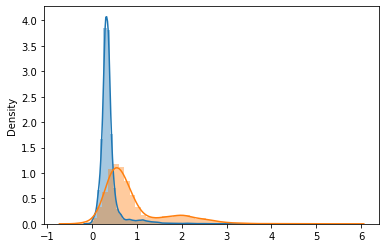

In [49]:
sns.distplot(predicted[0])
sns.distplot(expected_results[:,0])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



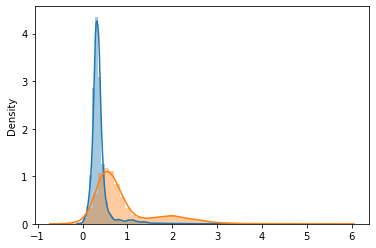

In [53]:
sns.distplot(predicted[0])
sns.distplot(expected_results[:,0])
plt.show()

/home/sdv/m2bi/aroubert/.conda/envs/KERAS/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


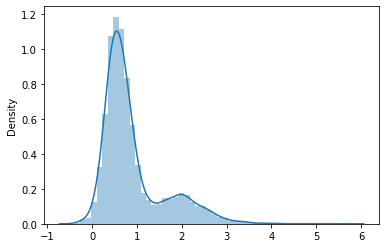

In [ ]:
sns.distplot(expected_results[:,0])
plt.show()

In [40]:
fig = pl.line(toto.history, y = ['loss', 'val_loss'], labels={'index':'epoch', 'value':'mse'})
fig.show()

**Revoir donnees a predire**

Prendre en compte bpps (mat 2d), fournir a dense (1 branche seq 1d, 1 branche bpps 2d, concatene a la fin)